In [226]:
import numpy as np
from numpy.linalg import inv, lstsq
from scipy.linalg import null_space
from scipy.ndimage.filters import *
from matplotlib.path import Path

# You may add support functions here, if desired.

#DLT Homography, code from ROB501 assignment 1
def dlt_homography(I1pts, I2pts):
    """
    Find perspective Homography between two images.

    Given 4 points from 2 separate images, compute the perspective homography
    (warp) between these points using the DLT algorithm.

    Parameters:
    ----------- 
    I1pts  - 2x4 np.array of points from Image 1 (each column is x, y).
    I2pts  - 2x4 np.array of points from Image 2 (in 1-to-1 correspondence).

    Returns:
    --------
    H  - 3x3 np.array of perspective homography (matrix map) between image coordinates.
    A  - 8x9 np.array of DLT matrix used to determine homography.
    """
    #--- FILL ME IN ---
    A = np.zeros([8,9])    #create the A matrix, an 8x9 np array
    
    for i,point in enumerate(I1pts.T):   #iterate over the vector of points in Image 1, transposed
        SecondImage = I2pts.T[i]           #find point in second image
        x = point[0]       #x coord 1st pic
        y = point[1]       # y coord 1st pic
        x_2 = SecondImage[0]          #x coord 2nd pic
        y_2 = SecondImage[1]           #y coord 2nd pic
        A_i = np.array([ [-1*x, -1*y, -1, 0 , 0 ,0, x_2*x, x_2*y, x_2],[0 ,0, 0, -1*x, -1*y, -1, y_2*x, y_2*y, y_2],])   
        # from formula in thesis paper ith element of A
        A[i*2 : (i+1)*2,:] = A_i   #finalize A matrix
    
    #create and reshape H matrix to a 3x3 np array
    H = null_space(A)
    H = H.reshape(3,3)
    last = H[2][2]            
    H = H * (1/last)        #normalize H 
    #------------------

    return H, A

def saddle_point(I):
    """
    Locate saddle point in an image patch.

    The function identifies the subpixel centre of a cross-junction in the
    image patch I, by fitting a hyperbolic paraboloid to the patch, and then 
    finding the critical point of that paraboloid.

    Note that the location of 'pt' is relative to (-0.5, -0.5) at the upper
    left corner of the patch, i.e., the pixels are treated as covering an 
    area of one unit square.

    Parameters:
    -----------
    I  - Single-band (greyscale) image patch as np.array (e.g., uint8, float).

    Returns:
    --------
    pt  - 2x1 np.array (float64), subpixel location of saddle point in I (x, y).
    """
    #--- FILL ME IN ---
 
    # Code goes here.
    rows = I.shape[0]  
    cols = I.shape[1]    #get dimensions for A and b, A is m*n by 6 and b is m*n by 1
                            # (x^2,xy,y^2,x,y,1) -> 6 elements
    
    dim = rows*cols
    #A_dim = (dim,6)
    
    
    A=np.zeros((dim,6)) #initialize A matrix to empty
    b=np.zeros((dim,1)) #initialize b vector to empty
    
    #now we need to populate the b vector with the image points
    i = 0
    for y in range(rows):
        for x in range(cols):
            b[i,0] = I[y,x]
            i=i+1
            
    #do the same for A matrix
    j=0
    for y in range(rows):
        for x in range(cols):
            A[j,:] = [x*x, x*y, y*y, x, y, 1]
            j=j+1
            
    #print(A)
    #print(b)
    
    Soln = lstsq(A,b,None)
    coeffs=Soln[0]
    alpha,beta,gamma,delta,epsilon,zeta  = coeffs.T[0]
    
    #print(alpha,beta,gamma,delta,epsilon, zeta)
    #once we have the coefficients, we can compose the solution
    
    v1 = [2*alpha, beta]
    v2 = [beta, 2*gamma]
    b1= [delta, epsilon]
    
    M=np.array([v1,v2])
    #print(M)
    x=np.array([[b1[0]],[b1[1]]])
    M_inv= inv(M)
    new_M = -1*M_inv
    #print(x)
    #print(new_M)
    #print(x)
    pt = (new_M).dot(x)
    
    #------------------

    correct = isinstance(pt, np.ndarray) and \
        pt.dtype == np.float64 and pt.shape == (2, 1)

    if not correct:
        raise TypeError("Wrong type or size returned!")

    return pt

def cross_junctions(I, bpoly, Wpts):
    """
    Find cross-junctions in image with subpixel accuracy.

    The function locates a series of cross-junction points on a planar 
    calibration target, where the target is bounded in the image by the 
    specified quadrilateral. The number of cross-junctions identified 
    should be equal to the number of world points.

    Note also that the world and image points must be in *correspondence*,
    that is, the first world point should map to the first image point, etc.

    Parameters:
    -----------
    I      - Single-band (greyscale) image as np.array (e.g., uint8, float).
    bpoly  - 2x4 np.array, bounding polygon (clockwise from upper left).
    Wpts   - 3xn np.array of world points (in 3D, on calibration target).

    Returns:
    --------
    Ipts  - 2xn np.array of cross-junctions (x, y), relative to the upper
            left corner of the target. The array must contain float64 values.
    """
    #--- FILL ME IN ---
    """For part 2, we are given a bpoly that contains 4 points which are the corners of the blue rectangular box if you run the learner example for visualization; as well as Wpts that includes the coordinates of the 48 points in 3D. Note that since those 48 points are coplanar, their z values don't matter, which effectively makes them 2D. 
 
Here we can try to apply what you mentioned, which is to find the homography between two set of points. Obiviously we need to locate the correponding points of the 4 bpoly corners in 3D, and we can do so by estimation based on the 4 extreme points of Wpts. Note that you are also given the side length of a square is 63.5mm in the assignment handout. You can use that with some scaling to estimate the 3D location of the corners."""

    # Code goes here...
    
    rows = I.shape[0]  #m
    cols = I.shape[1]  #n
    
    #Want to locate points of 4 bpoly corners, we are given the side length of a square is 63.5mm, we can scale this by 1000 to get the distance in m(note we dont care about z)
    d = 63.5 / 1000.0
    #scale for x border
    x_b = (1.0/3.0) * d 
    #scale for y border
    y_b = (1.0/5.0) * d 
    #find delta from junctions to border 
    dx = x_b + d
    dy = y_b + d
    
    #note that the above is in world points
    
    #find points of the corners, C1 is top left, C2 is top right, C3 is bottom left, C4 is bottom right
    
    C1 = Wpts[:,0:1]+ np.array([[-1*dx], [-1*dy],[0]])
    C2 = Wpts[:,7:8] + np.array([[dx], [-1*dy],[0]])
    C3 = Wpts[:,-8:-7] + np.array([[-1*dx], [dy],[0]])
    C4 = Wpts[:,-1:]+ np.array([[dx], [dy],[0]])
    combined = np.hstack([C1,C2,C4,C3])[:2,:]
    #print(combined)
    #use the homography process from assignment 1 to find transformation between the board frame and the distorted board in the picture
    H,A = dlt_homography(combined,bpoly)
    Wpts[2,:] = 1
    junctions = (H.dot(Wpts) / H.dot(Wpts)[2,:])[:2,:]  #
    #print(junctions)
    #Then use the saddle point function to find precise location in a patch around the predicted location
    results_list = []
    w = 8 #use some window around predicted points

    for index, row in enumerate(junctions.T):
        x,y =row
        x,y = int(x), int(y)
        #print(x)
        #print(y)
        #print(I[y-w:y+w,x-w:x+w])
        point_of_interest = saddle_point(I[y-w:y+w,x-w:x+w])
        results_list.append( [x - w + point_of_interest[0,0], y - w + point_of_interest[1,0]] )
    #JT = junctions.T   
    
    Ipts = np.array(results_list).T

    #------------------

    correct = isinstance(Ipts, np.ndarray) and \
        Ipts.dtype == np.float64 and Ipts.shape[0] == 2

    if not correct:
        raise TypeError("Wrong type or size returned!")

    return Ipts

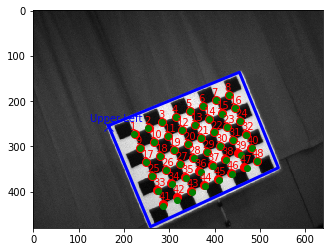

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
#from cross_junctions import cross_junctions
# Load the example target image.
# Load the world points.
Wpts = np.load('../data/world_pts.npy')
from imageio import imread, imwrite
I = imread("../targets/target_01.png")

# Load the bounding polygon.
bpoly = np.load('../data/bounds_01.npy')

# Load the reference solution and compute yours.
Ipts_ref = np.load('../data/cross_junctions_01.npy')
Ipts = cross_junctions(I, bpoly, Wpts)

# Plot the points to check!
plt.imshow(I, cmap = 'gray')

plt.plot(Ipts_ref[0, :], Ipts_ref[1, :], 'o', c = 'r', markersize = 8)
for i in range(0, Ipts_ref.shape[1]):
    plt.text(Ipts_ref[0, i] - 10, Ipts_ref[1, i] - 10, str(i + 1), c = 'r')

bpoly = np.append(bpoly, bpoly[:, None, 0], axis = 1) # Close the polygon.
plt.plot(bpoly[0, :], bpoly[1, :], '-', c = 'b', linewidth = 3)
plt.plot(bpoly[0, 0], bpoly[1, 0], 'x', c = 'b', markersize = 9)
plt.text(bpoly[0, 0] - 40, bpoly[1, 0] - 10, "Upper Left", c = 'b')

plt.plot(Ipts[0, :], Ipts[1, :], 'o', c = 'g',)
plt.show()

[[-0.08466667]
 [-0.0762    ]
 [ 0.        ]]
[[-0.08466667  0.52916667  0.52916667 -0.08466667]
 [-0.0762     -0.0762      0.3937      0.3937    ]]
[222.92464332 272.94708567]
[253.79548374 260.08133272]
[284.28664483 247.37381519]
[314.40508826 234.82163172]
[344.15760656 222.42195147]
[373.5508282  210.17201195]
[402.5912225 198.069117 ]
[431.28510441 186.11063479]
[235.39506681 302.94827851]
[266.16297348 289.90781551]
[296.55278156 277.02760328]
[326.57141801 264.30470594]
[356.22564163 251.73625889]
[385.52204809 239.31946666]
[414.46707485 227.05160084]
[443.06700589 214.92999808]
[247.84450401 332.89898278]
[278.50977872 319.68441382]
[308.79852925 306.6321002 ]
[338.71764802 293.73907177]
[368.27386026 281.00243045]
[397.47372902 268.41934802]
[426.32366005 255.98706405]
[454.82990648 243.70288388]
[260.27300785 362.79932583]
[290.83595131 349.41125268]
[321.02393869 336.18742873]
[350.84382806 323.12484984]
[380.30231123 310.22058464]
[409.40591879 297.47177241]
[438.16102494

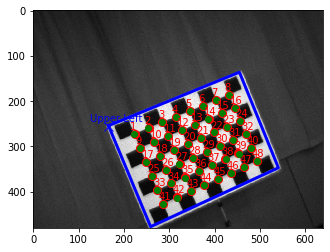

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
#from cross_junctions import cross_junctions

# Load the world points.
Wpts = np.load('../data/world_pts.npy')

# Load the example target image.
I = imread("../targets/target_01.png")

# Load the bounding polygon.
bpoly = np.load('../data/bounds_01.npy')

# Load the reference solution and compute yours.
Ipts_ref = np.load('../data/cross_junctions_01.npy')
Ipts = cross_junctions(I, bpoly, Wpts)

# Plot the points to check!
plt.imshow(I, cmap = 'gray')

plt.plot(Ipts_ref[0, :], Ipts_ref[1, :], 'o', c = 'r', markersize = 8)
for i in range(0, Ipts_ref.shape[1]):
    plt.text(Ipts_ref[0, i] - 10, Ipts_ref[1, i] - 10, str(i + 1), c = 'r')

bpoly = np.append(bpoly, bpoly[:, None, 0], axis = 1) # Close the polygon.
plt.plot(bpoly[0, :], bpoly[1, :], '-', c = 'b', linewidth = 3)
plt.plot(bpoly[0, 0], bpoly[1, 0], 'x', c = 'b', markersize = 9)
plt.text(bpoly[0, 0] - 40, bpoly[1, 0] - 10, "Upper Left", c = 'b')

plt.plot(Ipts[0, :], Ipts[1, :], 'o', c = 'g',)
plt.show()

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from pose_estimate_nls import pose_estimate_nls, hpose_from_epose
from dcm_from_rpy import dcm_from_rpy

# Camera intrinsics matrix - known.
K = np.array([[564.9, 0, 337.3], [0, 564.3, 226.5], [0, 0, 1]])

# Load landmark points (3D - ground truth).
Wpts = np.load('../data/world_pts.npy')

# Load initial guess for camera pose.
Twc_guess = np.load('../data/camera_pose_guess_01.npy')

# Load detected cross-junctions (2D - in image).
Ipts = np.load('../data/cross_junctions_01.npy')

Twc = pose_estimate_nls(K, Twc_guess, Ipts, Wpts)
print(Twc)

# Twc =
#     0.9159   -0.3804    0.1282    0.0932
#     0.3827    0.9239    0.0074   -0.0082
#    -0.1212    0.0423    0.9917   -1.0947
#          0         0         0    1.0000

# Plot the pose to check!
C = dcm_from_rpy(np.array([-np.pi/2, 0, 0]))
Wpts = C@Wpts # Rotate upright to visualize.
Twc = hpose_from_epose(np.array([0, 0, 0, -np.pi/2, 0, 0]))@Twc

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(Wpts[0, :], Wpts[1, :], Wpts[2, :], 'o', c = 'r')
ax.scatter3D(Twc[0, 3], Twc[1, 3], Twc[2, 3], 'o', c = 'b')
s = np.hstack((Twc[0:3, None, 3], Twc[0:3, None, 3], Twc[0:3, None, 3]))
e = 0.3*Twc[0:3, 0:3] + s
ax.plot3D([s[0, 0], e[0, 0]], [s[1, 0], e[1, 0]], [s[2, 0], e[2, 0]], 'r')
ax.plot3D([s[0, 1], e[0, 1]], [s[1, 1], e[1, 1]], [s[2, 1], e[2, 1]], 'g')
ax.plot3D([s[0, 2], e[0, 2]], [s[1, 2], e[1, 2]], [s[2, 2], e[2, 2]], 'b')
ax.auto_scale_xyz([-0.3, 0.7], [-1.5, 0.1], [-0.5, 0.5])
plt.show()

ModuleNotFoundError: No module named 'dcm_from_rpy'

In [325]:
import numpy as np
from numpy.linalg import inv

def find_jacobian(K, Twc, Wpt):
    """
    Determine the Jacobian for NLS camera pose optimization.

    The function computes the Jacobian of an image plane point with respect
    to the current camera pose estimate, given a landmark point. The 
    projection model is the simple pinhole model.

    Note that the homogeneous transformation matrix provided defines the
    transformation from the *camera frame* to the *world frame* (to 
    project into the image, you would need to invert this matrix).

    Parameters:
    -----------
    K    - 3x3 np.array, camera intrinsic calibration matrix.
    Twc  - 4x4 np.array, homogenous pose matrix, current guess for camera pose. 
    Wpt  - 3x1 world point on calibration target (one of n).

    Returns:
    --------
    J  - 2x6 np.array, Jacobian matrix (columns are tx, ty, tz, r, p, q).
         The Jacobian must contain float64 values.
    """
    #--- FILL ME IN ---
 
    # Code goes here...
    
    """
    Yaw = np.array([[np.cos(psi), -1*np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi),    0],
                   [0,         0,          1]])
                   
    Pitch = np.array([[np.cos(theta)       , 0       ,        np.sin(theta) ],
                   [0                , 1       ,        0          ],
                   [-1*np.sin(theta)    , 0       ,       np.cos(theta)  ]])
                   
    Roll = np.array([[1       , 0       , 0             ],
                   [0       , np.cos(phi),    -1*np.sin(phi)],
                   [0       , np.sin(phi),       np.cos(phi)]])
    
    Cwc = Yaw @ Pitch @ Roll"""
    
    """Process
    Part 1
- Find individual rotation matrices r,p,y
-determine Jacobian for each of this 3 rotation matrices using lecture 8 slide 28 
Part 2
- find translation jacobian for xyz
Part 3
- once you have all 6 jacobian x y z r p y, combine them into 3*6 matrix 
- now we use the formula to get ride of third row of this jacobian 
- the final value for Jacobean is the output"""
    
    
    ###PART 1
    #Extract rotation matrix,translation vector, world pt coords, and camera intrins parameters
    R = Twc[0:3,0:3]
    
    t = Twc[0:3,3]
    
    tx=t[0]
    ty=t[1]
    tz=t[2]
    
    WR=Wpt.reshape(3)
    wx=WR[0]
    wy=WR[1]
    wz=WR[2]

    flatK = K[0,:].flatten()
    flatK2 = K[1,1:].flatten()
    fx = flatK[0]
    s= flatK[1]
    cx=flatK[2]
    fy = flatK2[0]
    cy=flatK2[1]

    
    #compose inverse of the transform -R^(-1)*t (inverse of the transform), and find euler angles
    flatR = R.flatten()
    r1=flatR[0]
    r2=flatR[1]
    r3=flatR[2]
    r4=flatR[3]
    r5=flatR[4]
    r6=flatR[5]
    r7=flatR[6]
    r8=flatR[7]
    r9=flatR[8]
    yaw = np.arctan2(r4,r1)                           
    pitch = np.arctan2(-1*r7,np.sqrt(1-r7 ** 2))        
    roll = np.arctan2(r8,r9)        
    #inverse transform composition
    p1 = -1 * (r1 * tx + r4 * ty + r7 * tz)
    p2 = -1 * (r2 * tx + r5 * ty + r8 * tz)
    p3 = -1 * (r3 * tx + r6 * ty + r9 * tz)
        
    #on image
    ix_pro = wx*(fx*r1 + s*r2 + cx*r3) + wy*(fx*r4 + s*r5 + cx*r6) + wz*(fx*r7 + s*r8 + cx*r9) + fx*p1 + s*p2 + cx*p3
    iy_pro = wx*(fy*r2 + cy*r3) + wy*(fy*r5 + cy*r6) + wz*(fy*r8 + cy*r9) + fy*p2 + cy*p3

    ###PART 2
    
    ## A) First we find derivative of translation vector tx ty tz with respect to each component
    
    #step 1, compute dx/dtx, dy/dtx
    denom = r3 * wx + r6 * wy + r9 * wz + p3
    deriv_denom = -r3
    deriv_num = (fx * -1 * r1) + (s * -1 * r2) + (cx * -1 * r3)
    deriv_num2 = (fy * -1 * r2) + (cy * -1 * r3)
    dx_dtx = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtx = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    #step 2, compute dx/dty, dy/dty
    deriv_denom = -r6
    deriv_num = (fx * -1 * r4) + (s * -1 * r5) + (cx * -1 * r6)
    deriv_num2 = (fy * -1 * r5) + (cy * -1 * r6)
    dx_dty = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dty = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    #step 3, compute dx/dtz, dy/dtz
    deriv_denom = -r9
    deriv_num = (fx * -1 * r7) + (s * -1 * r8) + (cx * -1 * r9)
    deriv_num2 = (fy * -1 * r8) + (cy * -1 * r9)
    dx_dtz = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtz = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    ## B) Now find derivative on Rot matrix wrt to roll, pitch, yaw
    
    phi,theta,psi = roll,pitch,yaw
    
    #Encode matrices for Yaw pitch and Roll

    CYaw = np.array([[np.cos(psi), -1*np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi),    0],
                   [0,         0,          1]])
                   
    CPitch = np.array([[np.cos(theta)       , 0       ,        np.sin(theta) ],
                   [0                , 1       ,        0          ],
                   [-1*np.sin(theta)    , 0       ,       np.cos(theta)  ]])
                   
    CRoll = np.array([[1       , 0       , 0             ],
                   [0       , np.cos(phi),    -1*np.sin(phi)],
                   [0       , np.sin(phi),       np.cos(phi)]])
    
    # step 1, dx/dtyaw, dy/dtyaw
    dYaw = np.array([[-1*np.sin(psi), -1*np.cos(psi),    0],
                    [np.cos(psi)   , -1*np.sin(psi),    0],
                    [0          ,           0,    0]])
    
    
    dRoll = dYaw.dot(CPitch.dot(CRoll))
    flatdR = dRoll.flatten()
    dr1=flatdR[0]
    dr2=flatdR[1]
    dr3=flatdR[2]
    dr4=flatdR[3]
    dr5=flatdR[4]
    dr6=flatdR[5]
    dr7=flatdR[6]
    dr8=flatdR[7]
    dr9=flatdR[8]
    
    dp1 = -1*(tx*dr1 +ty*dr4 +tz*dr7) 
    dp2 = -1*(tx*dr2 +ty*dr5 +tz*dr8) 
    dp3 = -1*(tx*dr3 +ty*dr6 +tz*dr9) 
    deriv_denom = dr3 * wx + dr6 * wy + dr9 * wz + dp3
    deriv_num = wx*(fx  * dr1 + s * dr2 + cx * dr3) + wy*(fx*dr4 + s*dr5 + cx*dr6) + wz*(fx*dr7 + s*dr8 + cx*dr9) + fx * dp1 + s * dp2 + cx * dp3
    deriv_num2 = wx*(fy * dr2 + cy * dr3) + wy*(fy*dr5 + cy*dr6) + wz*(fy*dr8 + cy*dr9) + fy * dp2 + cy * dp3
    dx_dtq = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtq = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    #step 2, dx/dtroll, dy.dtroll
    #encode matrix, manually derived
    dRoll = np.array([[0       , 0        , 0             ],
                   [0       ,-1*np.sin(phi),    -1*np.cos(phi)],
                   [0       ,   np.cos(phi),    -1*np.sin(phi)]])
    
    dr = CYaw.dot(CPitch.dot(dRoll))
    flat_dR = dr.flatten()
    dr1=flat_dR[0]
    dr2=flat_dR[1]
    dr3=flat_dR[2]
    dr4=flat_dR[3]
    dr5=flat_dR[4]
    dr6=flat_dR[5]
    dr7=flat_dR[6]
    dr8=flat_dR[7]
    dr9=flat_dR[8]
    
    dp1 = -1*(tx*dr1 +ty*dr4 +tz*dr7) 
    dp2 = -1*(tx*dr2 +ty*dr5 +tz*dr8) 
    dp3 = -1*(tx*dr3 +ty*dr6 +tz*dr9) 
    
    deriv_denom = dr3 * wx + dr6 * wy + dr9 * wz + dp3
    deriv_num = wx*(fx  * dr1 + s * dr2 + cx * dr3) + wy*(fx*dr4 + s*dr5 + cx*dr6) + wz*(fx*dr7 + s*dr8 + cx*dr9) + fx * dp1 + s * dp2 + cx * dp3
    deriv_num2 = wx*(fy * dr2 + cy * dr3) + wy*(fy*dr5 + cy*dr6) + wz*(fy*dr8 + cy*dr9) + fy * dp2 + cy * dp3
    dx_dtr = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtr = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    # step 3, dx/dtpitch, dy/dtroll
    dPitch = np.array([[-1*np.sin(theta)       , 0       ,        np.cos(theta) ],
                   [0                    , 0       ,        0          ],
                   [-1*np.cos(theta)        , 0       ,    -1*np.sin(theta)  ]])
    dr = CYaw.dot(dPitch.dot(CRoll))
    #print(dYaw)
    #print(dcp)
    #print(CRoll)
    flat_dR = dr.flatten()
    dr1=flat_dR[0]
    dr2=flat_dR[1]
    dr3=flat_dR[2]
    dr4=flat_dR[3]
    dr5=flat_dR[4]
    dr6=flat_dR[5]
    dr7=flat_dR[6]
    dr8=flat_dR[7]
    dr9=flat_dR[8]
    
    dp1 = -1*(tx*dr1 +ty*dr4 +tz*dr7) 
    dp2 = -1*(tx*dr2 +ty*dr5 +tz*dr8) 
    dp3 = -1*(tx*dr3 +ty*dr6 +tz*dr9) 
    deriv_denom = dr3 * wx + dr6 * wy + dr9 * wz + dp3
    #print(denom)
    #print(deriv_denom)
    deriv_num = wx*(fx  * dr1 + s * dr2 + cx * dr3) + wy*(fx*dr4 + s*dr5 + cx*dr6) + wz*(fx*dr7 + s*dr8 + cx*dr9) + fx * dp1 + s * dp2 + cx * dp3
    dx_dtp = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    deriv_num2 = wx*(fy * dr2 + cy * dr3) + wy*(fy*dr5 + cy*dr6) + wz*(fy*dr8 + cy*dr9) + fy * dp2 + cy * dp3
    dx_dtp = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtp = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    ### PART 3, compose jacobian
    
    J = np.array([ [dx_dtx, dx_dty, dx_dtz, dx_dtr, dx_dtp, dx_dtq],
                   [dy_dtx, dy_dty, dy_dtz, dy_dtr, dy_dtp, dy_dtq]])

    #------------------

    correct = isinstance(J, np.ndarray) and \
        J.dtype == np.float64 and J.shape == (2, 6)

    if not correct:
        raise TypeError("Wrong type or size returned!")

    return J

In [311]:
import numpy as np
#from find_jacobian import find_jacobian

# Camera intrinsics matrix - known.
K = np.array([[564.9, 0, 337.3], [0, 564.3, 226.5], [0, 0, 1]])

# Arbitrary world point (landmark).
Wpt = np.array([[0.0635, 0, 0]]).T

# Camera pose (rotation matrix, translation vector).
C_cam = np.array([[ 0.960656116714365, -0.249483426036932,  0.122056730876061],
                  [-0.251971275568189, -0.967721063070012,  0.005140075795822],
                  [ 0.116834505638601, -0.035692635424156, -0.992509815603182]])
t_cam = np.array([[0.201090356081375, 0.114474051344464, 1.193821106321156]]).T

Twc = np.hstack((C_cam, t_cam))
Twc = np.vstack((Twc, np.array([[0, 0, 0, 1]])))
J = find_jacobian(K, Twc, Wpt)
print(J)

# Check your solution against the result below!
# J =
# -477.1016  121.4005   43.3460  -18.8900  592.2179  -71.3193
#  130.0713  468.1394  -59.8803  578.8882  -14.6399  -49.5217

[[-477.10156469  121.40047834   43.34599992  -18.89001611  592.21790979
   -71.31928406]
 [ 130.07128742  468.13944033  -59.88030594  578.88819411  -14.63994053
   -49.52168506]]


In [386]:
##MYTEST
import numpy as np
from numpy.linalg import inv, norm
#from find_jacobian import find_jacobian
from dcm_from_rpy import dcm_from_rpy
from rpy_from_dcm import rpy_from_dcm

#----- Functions Go Below -----

def epose_from_hpose(T):
    """Covert 4x4 homogeneous pose matrix to x, y, z, roll, pitch, yaw."""
    E = np.zeros((6, 1))
    E[0:3] = np.reshape(T[0:3, 3], (3, 1))
    E[3:6] = rpy_from_dcm(T[0:3, 0:3])
  
    return E

def hpose_from_epose(E):
    """Covert x, y, z, roll, pitch, yaw to 4x4 homogeneous pose matrix."""
    T = np.zeros((4, 4))
    T[0:3, 0:3] = dcm_from_rpy(E[3:6])
    T[0:3, 3] = np.reshape(E[0:3], (3,))
    T[3, 3] = 1
  
    return T

import numpy as np
from numpy.linalg import inv

def find_jacobian(K, Twc, Wpt):
    """
    Determine the Jacobian for NLS camera pose optimization.

    The function computes the Jacobian of an image plane point with respect
    to the current camera pose estimate, given a landmark point. The 
    projection model is the simple pinhole model.

    Note that the homogeneous transformation matrix provided defines the
    transformation from the *camera frame* to the *world frame* (to 
    project into the image, you would need to invert this matrix).

    Parameters:
    -----------
    K    - 3x3 np.array, camera intrinsic calibration matrix.
    Twc  - 4x4 np.array, homogenous pose matrix, current guess for camera pose. 
    Wpt  - 3x1 world point on calibration target (one of n).

    Returns:
    --------
    J  - 2x6 np.array, Jacobian matrix (columns are tx, ty, tz, r, p, q).
         The Jacobian must contain float64 values.
    """
    #--- FILL ME IN ---
 
    # Code goes here...
    
    """
    Yaw = np.array([[np.cos(psi), -1*np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi),    0],
                   [0,         0,          1]])
                   
    Pitch = np.array([[np.cos(theta)       , 0       ,        np.sin(theta) ],
                   [0                , 1       ,        0          ],
                   [-1*np.sin(theta)    , 0       ,       np.cos(theta)  ]])
                   
    Roll = np.array([[1       , 0       , 0             ],
                   [0       , np.cos(phi),    -1*np.sin(phi)],
                   [0       , np.sin(phi),       np.cos(phi)]])
    
    Cwc = Yaw @ Pitch @ Roll"""
    
    """Process
    Part 1
- Find individual rotation matrices r,p,y
-determine Jacobian for each of this 3 rotation matrices using lecture 8 slide 28 
Part 2
- find translation jacobian for xyz
Part 3
- once you have all 6 jacobian x y z r p y, combine them into 3*6 matrix 
- now we use the formula to get ride of third row of this jacobian 
- the final value for Jacobean is the output"""
    
    
    ###PART 1
    #Extract rotation matrix,translation vector, world pt coords, and camera intrins parameters
    R = Twc[0:3,0:3]
    
    t = Twc[0:3,3]
    
    tx=t[0]
    ty=t[1]
    tz=t[2]
    
    WR=Wpt.reshape(3)
    wx=WR[0]
    wy=WR[1]
    wz=WR[2]

    flatK = K[0,:].flatten()
    flatK2 = K[1,1:].flatten()
    fx = flatK[0]
    s= flatK[1]
    cx=flatK[2]
    fy = flatK2[0]
    cy=flatK2[1]

    
    #compose inverse of the transform -R^(-1)*t (inverse of the transform), and find euler angles
    flatR = R.flatten()
    r1=flatR[0]
    r2=flatR[1]
    r3=flatR[2]
    r4=flatR[3]
    r5=flatR[4]
    r6=flatR[5]
    r7=flatR[6]
    r8=flatR[7]
    r9=flatR[8]
    yaw = np.arctan2(r4,r1)                           
    pitch = np.arctan2(-1*r7,np.sqrt(1-r7 ** 2))        
    roll = np.arctan2(r8,r9)        
    #inverse transform composition
    p1 = -1 * (r1 * tx + r4 * ty + r7 * tz)
    p2 = -1 * (r2 * tx + r5 * ty + r8 * tz)
    p3 = -1 * (r3 * tx + r6 * ty + r9 * tz)
        
    #on image
    ix_pro = wx*(fx*r1 + s*r2 + cx*r3) + wy*(fx*r4 + s*r5 + cx*r6) + wz*(fx*r7 + s*r8 + cx*r9) + fx*p1 + s*p2 + cx*p3
    iy_pro = wx*(fy*r2 + cy*r3) + wy*(fy*r5 + cy*r6) + wz*(fy*r8 + cy*r9) + fy*p2 + cy*p3

    ###PART 2
    
    ## A) First we find derivative of translation vector tx ty tz with respect to each component
    
    #step 1, compute dx/dtx, dy/dtx
    denom = r3 * wx + r6 * wy + r9 * wz + p3
    deriv_denom = -r3
    deriv_num = (fx * -1 * r1) + (s * -1 * r2) + (cx * -1 * r3)
    deriv_num2 = (fy * -1 * r2) + (cy * -1 * r3)
    dx_dtx = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtx = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    #step 2, compute dx/dty, dy/dty
    deriv_denom = -r6
    deriv_num = (fx * -1 * r4) + (s * -1 * r5) + (cx * -1 * r6)
    deriv_num2 = (fy * -1 * r5) + (cy * -1 * r6)
    dx_dty = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dty = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    #step 3, compute dx/dtz, dy/dtz
    deriv_denom = -r9
    deriv_num = (fx * -1 * r7) + (s * -1 * r8) + (cx * -1 * r9)
    deriv_num2 = (fy * -1 * r8) + (cy * -1 * r9)
    dx_dtz = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtz = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    ## B) Now find derivative on Rot matrix wrt to roll, pitch, yaw
    
    phi,theta,psi = roll,pitch,yaw
    
    #Encode matrices for Yaw pitch and Roll

    CYaw = np.array([[np.cos(psi), -1*np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi),    0],
                   [0,         0,          1]])
                   
    CPitch = np.array([[np.cos(theta)       , 0       ,        np.sin(theta) ],
                   [0                , 1       ,        0          ],
                   [-1*np.sin(theta)    , 0       ,       np.cos(theta)  ]])
                   
    CRoll = np.array([[1       , 0       , 0             ],
                   [0       , np.cos(phi),    -1*np.sin(phi)],
                   [0       , np.sin(phi),       np.cos(phi)]])
    
    # step 1, dx/dtyaw, dy/dtyaw
    dYaw = np.array([[-1*np.sin(psi), -1*np.cos(psi),    0],
                    [np.cos(psi)   , -1*np.sin(psi),    0],
                    [0          ,           0,    0]])
    
    
    dRoll = dYaw.dot(CPitch.dot(CRoll))
    flatdR = dRoll.flatten()
    dr1=flatdR[0]
    dr2=flatdR[1]
    dr3=flatdR[2]
    dr4=flatdR[3]
    dr5=flatdR[4]
    dr6=flatdR[5]
    dr7=flatdR[6]
    dr8=flatdR[7]
    dr9=flatdR[8]
    
    dp1 = -1*(tx*dr1 +ty*dr4 +tz*dr7) 
    dp2 = -1*(tx*dr2 +ty*dr5 +tz*dr8) 
    dp3 = -1*(tx*dr3 +ty*dr6 +tz*dr9) 
    deriv_denom = dr3 * wx + dr6 * wy + dr9 * wz + dp3
    deriv_num = wx*(fx  * dr1 + s * dr2 + cx * dr3) + wy*(fx*dr4 + s*dr5 + cx*dr6) + wz*(fx*dr7 + s*dr8 + cx*dr9) + fx * dp1 + s * dp2 + cx * dp3
    deriv_num2 = wx*(fy * dr2 + cy * dr3) + wy*(fy*dr5 + cy*dr6) + wz*(fy*dr8 + cy*dr9) + fy * dp2 + cy * dp3
    dx_dtq = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtq = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    #step 2, dx/dtroll, dy.dtroll
    #encode matrix, manually derived
    dRoll = np.array([[0       , 0        , 0             ],
                   [0       ,-1*np.sin(phi),    -1*np.cos(phi)],
                   [0       ,   np.cos(phi),    -1*np.sin(phi)]])
    
    dr = CYaw.dot(CPitch.dot(dRoll))
    flat_dR = dr.flatten()
    dr1=flat_dR[0]
    dr2=flat_dR[1]
    dr3=flat_dR[2]
    dr4=flat_dR[3]
    dr5=flat_dR[4]
    dr6=flat_dR[5]
    dr7=flat_dR[6]
    dr8=flat_dR[7]
    dr9=flat_dR[8]
    
    dp1 = -1*(tx*dr1 +ty*dr4 +tz*dr7) 
    dp2 = -1*(tx*dr2 +ty*dr5 +tz*dr8) 
    dp3 = -1*(tx*dr3 +ty*dr6 +tz*dr9) 
    
    deriv_denom = dr3 * wx + dr6 * wy + dr9 * wz + dp3
    deriv_num = wx*(fx  * dr1 + s * dr2 + cx * dr3) + wy*(fx*dr4 + s*dr5 + cx*dr6) + wz*(fx*dr7 + s*dr8 + cx*dr9) + fx * dp1 + s * dp2 + cx * dp3
    deriv_num2 = wx*(fy * dr2 + cy * dr3) + wy*(fy*dr5 + cy*dr6) + wz*(fy*dr8 + cy*dr9) + fy * dp2 + cy * dp3
    dx_dtr = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtr = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    # step 3, dx/dtpitch, dy/dtroll
    dPitch = np.array([[-1*np.sin(theta)       , 0       ,        np.cos(theta) ],
                   [0                    , 0       ,        0          ],
                   [-1*np.cos(theta)        , 0       ,    -1*np.sin(theta)  ]])
    dr = CYaw.dot(dPitch.dot(CRoll))
    #print(dYaw)
    #print(dcp)
    #print(CRoll)
    flat_dR = dr.flatten()
    dr1=flat_dR[0]
    dr2=flat_dR[1]
    dr3=flat_dR[2]
    dr4=flat_dR[3]
    dr5=flat_dR[4]
    dr6=flat_dR[5]
    dr7=flat_dR[6]
    dr8=flat_dR[7]
    dr9=flat_dR[8]
    
    dp1 = -1*(tx*dr1 +ty*dr4 +tz*dr7) 
    dp2 = -1*(tx*dr2 +ty*dr5 +tz*dr8) 
    dp3 = -1*(tx*dr3 +ty*dr6 +tz*dr9) 
    deriv_denom = dr3 * wx + dr6 * wy + dr9 * wz + dp3
    #print(denom)
    #print(deriv_denom)
    deriv_num = wx*(fx  * dr1 + s * dr2 + cx * dr3) + wy*(fx*dr4 + s*dr5 + cx*dr6) + wz*(fx*dr7 + s*dr8 + cx*dr9) + fx * dp1 + s * dp2 + cx * dp3
    dx_dtp = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    deriv_num2 = wx*(fy * dr2 + cy * dr3) + wy*(fy*dr5 + cy*dr6) + wz*(fy*dr8 + cy*dr9) + fy * dp2 + cy * dp3
    dx_dtp = (denom * deriv_num - deriv_denom * ix_pro) / (denom ** 2)
    dy_dtp = (denom * deriv_num2 - deriv_denom * iy_pro) / (denom ** 2)
    
    ### PART 3, compose jacobian
    
    J = np.array([ [dx_dtx, dx_dty, dx_dtz, dx_dtr, dx_dtp, dx_dtq],
                   [dy_dtx, dy_dty, dy_dtz, dy_dtr, dy_dtp, dy_dtq]])

    #------------------

    correct = isinstance(J, np.ndarray) and \
        J.dtype == np.float64 and J.shape == (2, 6)

    if not correct:
        raise TypeError("Wrong type or size returned!")

    return J

def pose_estimate_nls(K, Twc_guess, Ipts, Wpts):
    """Estimate camera pose from 2D-3D correspondences via NLS.

    The function performs a nonlinear least squares optimization procedure 
    to determine the best estimate of the camera pose in the calibration
    target frame, given 2D-3D point correspondences.

    Parameters:
    -----------
    K          - 3x3 camera intrinsic calibration matrix.
    Twc_guess  - 4x4 homogenous pose matrix, initial guess for camera pose.
    Ipts       - 2xn array of cross-junction points (with subpixel accuracy).
    Wpts       - 3xn array of world points (one-to-one correspondence with Ipts).

    Returns:
    --------
    Twc  - 4x4 np.array (float64), pose matrix, camera pose in target frame."""
    maxIters = 250                          # Set maximum iterations.

    tp = Ipts.shape[1]                      # Num points.
    ps = np.reshape(Ipts, (2*tp, 1), 'F')   # Stacked vector of observations.

    dY = np.zeros((2*tp, 1))                # Residuals.
    J  = np.zeros((2*tp, 6))                # Jacobian.

    #--- FILL ME IN ---

    # Some hints on structure are included below...

    # 1. Convert initial guess to parameter vector (6 x 1).
    # ...

    iter = 1
   
    
    #error threshold
    eps = 0.0000001
    #get the original parameters
    params = epose_from_hpose(Twc_guess) 
    
    # 2. Main loop - continue until convergence or maxIters.
    while iter <= maxIters:
        # 3. Save previous best pose estimate.
        # ...
        params_prev = params
        curr_Twc = hpose_from_epose(params_prev)
        curr_R = curr_Twc[0:3,0:3]
        curr_t = curr_Twc[0:3,3:4]
        
         # 4. Project each landmark into image, given current pose estimate.
        for i in np.arange(tp):
       
            #get jacobian for current point
            WPT=Wpts[0:3,i:i+1]
            J_curr = find_jacobian(K, curr_Twc, WPT)
            
            #update J
            J[2*i:2*i+2,0:6] = J_curr
            
            #current landmark estimate
            CLE = K.dot(curr_R.T).dot(WPT-curr_t)
            
            #error for current landmark estimate, and update residual
            err=(CLE/CLE[2,0])[0:2,0:1] - Ipts[0:2,i:i+1]
            dY[2*i:2*i+2,0:1]=err
        
        
            pass
       
        #for i in np.arange(tp):
           # pass

        # 5. Solve system of normal equations for this iteration.
        # ...
        JT = J.T
        #dx = np.dot(np.dot( inv(np.dot(J.T,J)),J.T),dY)
        dx = -1*inv(JT.dot(J)).dot(JT).dot(dY)
        #update params in direction of dx
        
        params = params_prev + dx

        Twc = hpose_from_epose(params)
        # 6. Check - converged?
        diff = norm(params - params_prev)

        if norm(diff) < 1e-12:
            print("Covergence required %d iters." % iter)
            break
        elif iter == maxIters:
            print("Failed to converge after %d iters." % iter)
            break
        
        iter += 1

    # 7. Compute and return homogeneous pose matrix Twc.
    

    #------------------

    correct = isinstance(Twc, np.ndarray) and \
        Twc.dtype == np.float64 and \
        Twc.shape == (4, 4) and Twc[3, 3] == 1.0000

    if not correct:
        raise TypeError("Wrong type or size returned!")

    return Twc
    


In [389]:
import numpy as np
import matplotlib.pyplot as plt
#from pose_estimate_nls import pose_estimate_nls, hpose_from_epose
from dcm_from_rpy import dcm_from_rpy

# Camera intrinsics matrix - known.
K = np.array([[564.9, 0, 337.3], [0, 564.3, 226.5], [0, 0, 1]])

# Load landmark points (3D - ground truth).
Wpts = np.load('../data/world_pts.npy')

# Load initial guess for camera pose.
Twc_guess = np.load('../data/camera_pose_guess_01.npy')

# Load detected cross-junctions (2D - in image).
Ipts = np.load('../data/cross_junctions_01.npy')

Twc = pose_estimate_nls(K, Twc_guess, Ipts, Wpts)
print(Twc)

# Twc =
#     0.9159   -0.3804    0.1282    0.0932
#     0.3827    0.9239    0.0074   -0.0082
#    -0.1212    0.0423    0.9917   -1.0947
#          0         0         0    1.0000

# Plot the pose to check!
C = dcm_from_rpy(np.array([-np.pi/2, 0, 0]))
Wpts = C@Wpts # Rotate upright to visualize.
Twc = hpose_from_epose(np.array([0, 0, 0, -np.pi/2, 0, 0]))@Twc

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(Wpts[0, :], Wpts[1, :], Wpts[2, :], 'o', c = 'r')
ax.scatter3D(Twc[0, 3], Twc[1, 3], Twc[2, 3], 'o', c = 'b')
s = np.hstack((Twc[0:3, None, 3], Twc[0:3, None, 3], Twc[0:3, None, 3]))
e = 0.3*Twc[0:3, 0:3] + s
ax.plot3D([s[0, 0], e[0, 0]], [s[1, 0], e[1, 0]], [s[2, 0], e[2, 0]], 'r')
ax.plot3D([s[0, 1], e[0, 1]], [s[1, 1], e[1, 1]], [s[2, 1], e[2, 1]], 'g')
ax.plot3D([s[0, 2], e[0, 2]], [s[1, 2], e[1, 2]], [s[2, 2], e[2, 2]], 'b')
ax.auto_scale_xyz([-0.3, 0.7], [-1.5, 0.1], [-0.5, 0.5])
plt.show()

Covergence required 8 iters.
[[ 0.91578261 -0.38048519  0.12873702  0.09361725]
 [ 0.3827585   0.92381737  0.00757556 -0.00588543]
 [-0.12181189  0.04233763  0.99164983 -1.09481033]
 [ 0.          0.          0.          1.        ]]


ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>